## Demonstration of Audio Denoising

This jupyter notebook is part of a [collection of notebooks](../index.ipynb) on various topics of Data-Driven Signal Processing. Please direct questions and suggestions to [Sascha.Spors@uni-rostock.de](mailto:Sascha.Spors@uni-rostock.de).

The denoising of audio samples is demonstrated using a deep neural regression network consisting of fully-connected layers. The noisy input signal is split into overlapping segments and the magnitude of the short-time Fourier transform (STFT) of the current and 7 past segments is used as feature. The output for the supervised training is the magnitude of the STFT of the current segment of the noise-free signal.

This example was inspired by the paper of Liu, D. & Smaragdis, P. & Kim, Minje. (2014). Experiments on deep learning for speech denoising. Proceedings of the Annual Conference of the International Speech Communication Association, INTERSPEECH. 2685-2689.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf

from scipy.signal import decimate
from librosa import stft, istft

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Input, Dense, Activation, Flatten, Normalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
training_path = '../data/froschkoenig_female_speaker.wav'  # clean audio file used for training
noise_path = '../data/babble_noise.wav'  # additive noise for impairment of clean audio
testing_path = '../data/single_words_female_speaker.wav'  # clean audio used for testing the network

### Generate Examples

The features/outputs used for training the regression network are computed by impairing a clean speech recording by babble noise.

In [3]:
def generate_features(y, n, n_fft=256, hop_length=64, nseg=8):

    # normalize inputs
    y = y/np.max(np.abs(y[:]))
    n = n/np.max(np.abs(n[:]))

    # add background noise to signal
    x = y + .7 * n[:len(y)]
    x = x/np.max(np.abs(x[:]))

    # STFTs of clean and noisy signal
    Y = stft(y, n_fft=n_fft, hop_length=hop_length).T
    Y = np.abs(Y)
    X = stft(x, n_fft=n_fft, hop_length=hop_length).T
    phiX = np.angle(X[nseg-1:, :])
    X = np.abs(X)

    # stack segments as features
    Y = Y[nseg-1:, :]
    X = [X[n:n+nseg, :] for n in range(len(Y))]
    X = np.array(X)

    return X, x, Y, phiX

In [4]:
y, fs = sf.read(training_path)
y = decimate(y, 2)
fs = fs//2

n, _ = sf.read(noise_path)
n = n[:, 0]
n = decimate(n, 2)
n = np.hstack((n, n, n))

X, x, Y, phiX = generate_features(y, n)

print(f'dimensions of features {X.shape}')
print(f'dimensions of outputs {Y.shape}')

dimensions of features (49956, 8, 129)
dimensions of outputs (49956, 129)


Let's listen to the noisy audio used for the training

In [5]:
sf.write('training_example.wav', x, fs)

<audio src="training_example.wav" controls>

### Define and Train the Model

The model is defined as a concatenation of an input layer, a normalization layer, two hidden layers and an output layer. For the model, the output shapes of the individual layers, as well as the number of parameters that have to be determined in the training phase are summarized.

In [6]:
normalizer = Normalization(axis=None)


def dnn_model(input_shape=(8, 129)):

    inputs = Input(shape=input_shape)

    x = normalizer(inputs)

    x = Dense(1024)(x)
    x = Activation('relu')(x)

    x = Dense(1024)(x)
    x = Activation('relu')(x)

    x = Flatten()(x)
    x = Dense(129, activation='relu')(x)

    return Model(inputs, x)


model = dnn_model()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 8, 129)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization (Normalization)   │ (None, 8, 129)         │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8, 1024)        │       133,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 8, 1024)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8, 1024)        │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 8, 1024)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 129)            │     1,056,897 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,239,620 (8.54 MB)

 Trainable params: 2,239,617 (8.54 MB)

 Non-trainable params: 3 (16.00 B)

Now the model is 'compiled' using the mean-squared error (MSE) as loss function together with the Adam optimizer. The examples are split into two subsets of training and validation examples. In order to avoid overfitting, Early Stopping is used to stop the training after convergence has been reached.

In [7]:
model.compile(loss="mse", optimizer="adam")

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

normalizer.adapt(X_train)

callback = EarlyStopping(monitor='val_loss', patience=5)
history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test),
                    callbacks=[callback], epochs=100, batch_size=64)

Epoch 1/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 46s 73ms/step - loss: 0.2732 - val_loss: 0.1557
Epoch 2/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 46s 74ms/step - loss: 0.1345 - val_loss: 0.1344
Epoch 3/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 46s 74ms/step - loss: 0.1113 - val_loss: 0.1055
Epoch 4/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 46s 73ms/step - loss: 0.0969 - val_loss: 0.1020
Epoch 5/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 46s 74ms/step - loss: 0.0876 - val_loss: 0.0907
Epoch 6/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 46s 74ms/step - loss: 0.0798 - val_loss: 0.0874
Epoch 7/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 46s 74ms/step - loss: 0.0736 - val_loss: 0.0880
Epoch 8/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 46s 73ms/step - loss: 0.0677 - val_loss: 0.0811
Epoch 9/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 46s 74ms/step - loss: 0.0631 - val_loss: 0.0782
Epoch 10/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 45s 73ms/step - loss: 0.0581 - val_loss: 0.0731
Epoch 11/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 45s 73ms/step - loss: 0.0538 - val_loss: 0.0710
Epoch 12/100
625/62

### Evaluation of the Model

First we take a look at the evolution of the mean-squared error over the epochs.

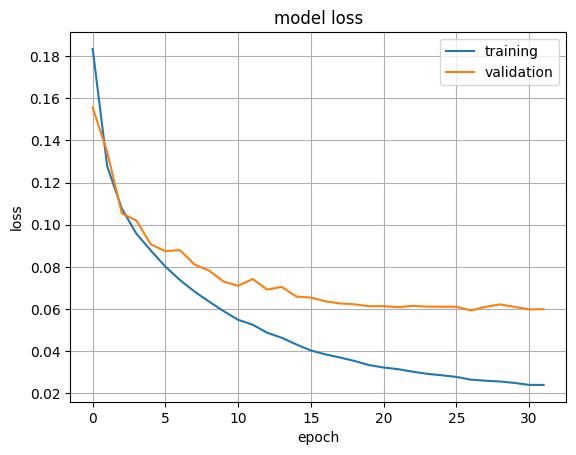

In [8]:
def plot_history(history, key):
    plt.figure()
    plt.plot(history.history[key], label='training')
    plt.plot(history.history[f'val_{key}'], label='validation')
    plt.title(f'model {key}')
    plt.ylabel(key)
    plt.xlabel('epoch')
    plt.legend()
    plt.grid()


plot_history(history, 'loss')

In order to test the model, an unseen audio example is denoised by the trained model. In order to denoise the signal with the trained network, the phase is extracted from the STFT before taking its magnitude. The input features are then fed through the network in order to compute the denoised STFT of the actual segment. The extracted phase is then used to recover the output segment using an inverse STFT.

In [9]:
y_test, _ = sf.read(testing_path)
y_test = decimate(y_test, 2)

X_test, x_test, Y_test, phiX_test = generate_features(y_test, n)

Yd = model.predict(X_test)
yd = istft(Yd.T * np.exp(1j*phiX_test).T)
yd = yd / np.max(np.abs(yd[:]))

sf.write('clean_example.wav', y_test, fs)
sf.write('noisy_example.wav', x_test, fs)
sf.write('denoised_example.wav', yd, fs)

194/194 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step


Lets listen to the noisy and denoised example to explore the performance of the model

**Clean example**

<audio src="clean_example.wav" controls>

**Example impaired by babble noise**

<audio src="noisy_example.wav" controls>

**Denoised example**

<audio src="denoised_example.wav" controls>

**Copyright**

This notebook is provided as [Open Educational Resource](https://de.wikipedia.org/wiki/Open_Educational_Resources).
The text is licensed under [Creative Commons Attribution 4.0](https://creativecommons.org/licenses/by/4.0/)
, the code of the IPython examples under the [MIT license](https://opensource.org/licenses/MIT). Please attribute the work as follows: Sascha Spors, Data driven audio signal processing - Lecture supplementals.